# import packages and read h5 files

In [1]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import MultipleLocator, FuncFormatter, MaxNLocator, ScalarFormatter, FixedLocator, LogFormatter

import datetime
from matplotlib import rc
from cycler import cycler

import numpy as np
import pandas as pd


# download and install Dr. Jin's python package, click the url below for more details
# !git clone https://github.com/jinwar/jin_pylib

from jin_pylib import gjsignal
from jin_pylib import Data2D_XT


In [2]:
# Read h5 files
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 3 (refrac)/Neubrex_DSS_strain/Zgabay A14H - refrac - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/Zgabay A14H - pop - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 6 (choke)/Zgabay A14H - choke - strain change rate.h5','r')
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/Zgabay A14H - flowback - strain change.h5','r')


print(list(f1.keys()))

['data', 'depth', 'stamps', 'stamps_unix']


# Waterfall plot

In [3]:
from matplotlib import rc
from cycler import cycler

# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

In [4]:
# Assign variables
dstrain = (f1['data'])  #（time, depth）
depth = (f1['depth'])
date_plot = (f1['stamps'])

# use panda package
# print(pd.DataFrame(dstrain))
print(pd.DataFrame(depth))
# print(pd.DataFrame(date_plot))

                  0
0          0.039095
1          0.372001
2          0.701719
3          1.031387
4          1.364292
...             ...
57199  18922.408203
57200  18922.738281
57201  18923.070312
57202  18923.398438
57203  18923.728516

[57204 rows x 1 columns]


In [5]:
# convert the strain data to numpy array
dstrain = np.array(dstrain)
print(dstrain.shape)

# date_plot = np.array(date_plot)

(3415, 57204)


In [6]:
#depth 和相邻depth的差值
print(np.diff(depth))
average_diff = np.mean(np.diff(depth))
print(average_diff)


[0.3329055  0.32971793 0.32966805 ... 0.33203125 0.328125   0.33007812]
0.3308164


In [7]:
# deal with time array
# print(type(date_plot))  # h5py._hl.dataset.Dataset
# 1) encoding 
arr_bytes = date_plot[...]                      # numpy.ndarray
# print(type(arr_bytes),"arr_bytes")              # numpy.ndarray
arr_str   = np.char.decode(arr_bytes, 'utf-8')  # 向量化解码为 ndarray[str]
# print(type(arr_str),"arr_str")                      # ndarray[str]
datetime_index = pd.to_datetime(arr_str, format="%m/%d/%Y %H:%M:%S.%f")
# print(type(datetime_index))                           # pandas.core.indexes.datetimes.DatetimeIndex
# print("datetime_index\n",datetime_index)

# 2) calculate the start time
dtimes = datetime_index.to_pydatetime()  # type = numpy.ndarray, element type = datetime.datetime
startdate = dtimes[0]
print("startdate-->",startdate)  # 2022-03-14 20:56:49.350706

# 3) calculate average time interval in seconds
deltas = datetime_index.to_series().diff().dropna()   # dropna() 去掉第一个 NaT
print("deltas-->",type(deltas),"\nelement inside-->",type(deltas.iloc[0]))  # pandas.core.series.Series，元素类型为 Timedelta
mean_seconds = deltas.dt.total_seconds().mean()
print("mean_seconds",type(mean_seconds))  # float
print("平均间隔 (秒):", mean_seconds)


# 4) set the time axis for DASdata
t_intrvl = np.round(mean_seconds) # time interval in seconds 
t_axis = 1 + t_intrvl * np.arange(len(date_plot))        # array([1, 146, 291, ...])
t_axis = t_axis.tolist() 


# ts_np = np.array(ts)   # 如果 ts 是 DatetimeIndex，这会生成 datetime64[ns] 数组

# # 1) 计算相邻差（结果是 timedelta64[ns]）
# diffs = np.diff(ts_np)

# # 2) 把 timedelta64[ns] 转换为秒（浮点）
# # 方法：astype('timedelta64[ns]') -> 将其转换为数值（以 ns 为单位），然后除以 1e9
# diffs_ns = diffs.astype('timedelta64[ns]').astype(np.int64)   # ns 为单位的整数
# diffs_seconds = diffs_ns / 1e9

# # 3) 平均秒数
# mean_seconds = np.mean(diffs_seconds)

# print("前 5 个相邻差值（秒）:", diffs_seconds[:5])
# print("平均间隔 (秒):", mean_seconds)


startdate--> 2022-06-01 07:46:11.600838
deltas--> <class 'pandas.core.series.Series'> 
element inside--> <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
mean_seconds <class 'numpy.float64'>
平均间隔 (秒): 154.44229406121852


In [8]:
data = dstrain #(time, depth）

# creating a Data2D class instance

DASdata = Data2D_XT.Data2D() # initiate instance
DASdata.data = data.T   # DAS data in 2D array, the first axis is distance and second axis is time

# DASdata.taxis = pd.date_range(start = date_plot[0],end = date_plot[-1],periods = len(date_plot))
DASdata.taxis = t_axis

DASdata.daxis = np.arange(data.shape[1])*average_diff  # 1D array for distance grid, unit in ft
DASdata.start_time = startdate

DASdata.daxis[-1]
print(DASdata.data.shape)

(57204, 3415)


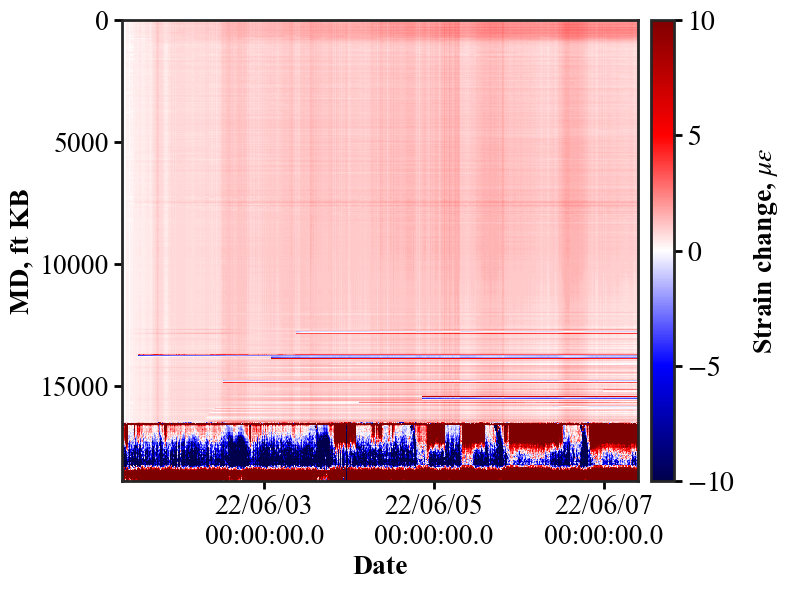

In [9]:
# cx = np.array([-1,1])
# DASdata.plot_waterfall(timescale='second',use_timestamp=True,timefmt = '%m/%d\n%H:%M:%S.{ms}')
fig, ax = plt.subplots(figsize = (8,6))
DASdata.plot_waterfall(timescale='second',use_timestamp=True,cmap=plt.get_cmap('seismic'),xtickN=4)
ax = plt.gca()
im = ax.images[-1]
im.set_norm(TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10))  # 以 0 为中心
# 或者：im.set_clim(-10, 10)

cbar = fig.colorbar(im, ax=ax, pad=0.02) # pad 调整颜色条与图的距离pad 数值越大越远（相对于轴宽度的比例）
cbar.set_label(r'Strain change, $\mu\varepsilon$', rotation=90, labelpad=10)

ax.set_ylabel("MD, ft KB", fontweight='bold')
ax.set_xlabel("Date",     fontweight='bold')

# -----------------set custom ticks--------------

# # X 轴
# ax.set_xticks([t0, t1, t2])                     # 位置（数据坐标）
# ax.set_xticklabels(['Start', 'Mid', 'End'])     # 文本（与上面位置一一对应）

# # Y 轴
# ax.set_yticks([0, 5000, 10000])
# ax.set_yticklabels(['0', '5k', '10k'])

# 均匀间隔
# ax.xaxis.set_major_locator(MultipleLocator(3600))     # 每 3600 秒一个大刻度
ax.yaxis.set_major_locator(MultipleLocator(5000))     # 每 2000 ft 一个大刻度

# # 控制刻度文本格式（自定义函数）
# ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'{v/3600:.1f} h'))
# ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'{v:.0f}'))

# # 或者仅控制“最多几个刻度”
# ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

# # cbar
# 位置：固定到想要的几档
cbar.set_ticks([-10, -5, 0, 5, 10])                 # 或 cbar.ax.yaxis.set_major_locator(FixedLocator([...]))
# 文本：逐个指定（可含数学字体）
cbar.set_ticklabels([r'$-10$', r'$-5$', r'$0$', r'$5$', r'$10$'])

# # 或者用 Formatter 自动生成文本
# cbar.formatter = FuncFormatter(lambda v, pos: f'{v:.1f}')
# cbar.update_normal(im)   # 某些版本需要刷新一下

# 标签（单位）
cbar.set_label(r'Strain change, $\mu\varepsilon$', rotation=90, labelpad=12)


plt.tight_layout()
plt.savefig('waterfall_ori.png',dpi=1200)


# Strain change v.s. Time at certain depths

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\fengxiang.mao\AppData\Local\Temp\ipykernel_2380\1685038515.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Strain Change, $\mu\epsilon$',fontweight = 'bold',fontsize=20)


<Figure size 1200x600 with 0 Axes>

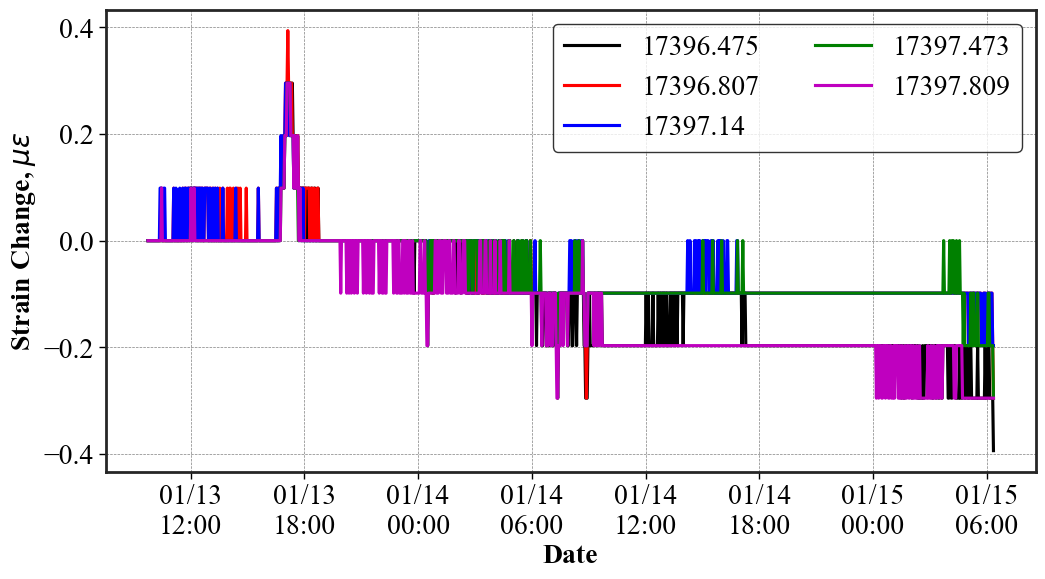

In [22]:
plt.figure()
fig, ax = plt.subplots(figsize = (12,6))
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=1, length=5)

for i in range(len(chosenMD)):
    plt.plot(dtimes[:1120], dstrain[:1120,chosenMD[i]], linewidth = 2.25,label = eltsMD[i] )
    plt.xlabel("Date", fontweight = 'bold', fontsize=20)
    plt.ylabel('Strain Change, $\mu\epsilon$',fontweight = 'bold',fontsize=20)
    plt.legend(loc='best',ncol = 2,
               fontsize = 20, edgecolor = 'black')
# plt.plot(t_date[:1120],dstrain[:1120,52173])
plt.tick_params(axis='both', which='minor', labelsize=20)
ax.grid(color='gray', linestyle='--', linewidth = 0.5)
plt.tick_params(axis='both', which='major', labelsize=20, direction='out',
                top=False, right=False)
ax = plt.gca()
ax.xaxis_date()
date_format = mdates.DateFormatter('%m/%d\n%H:%M')
ax.xaxis.set_major_formatter(date_format)
# ax.tick_params(axis='x',labelrotation=45)
# plt.savefig(f'ori_chan{chosenMD[0]}.svg')